In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from scipy import stats
%matplotlib inline
from sklearn import model_selection
from sklearn import linear_model
from sklearn import feature_selection as fs
from sklearn import metrics

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
with open('epi_r.csv') as f:
    df = pd.read_csv(f)

In [5]:
df.shape

(20052, 680)

### Задача: обучить модель предсказывать рэйтинг блюда

Необходимо сделать следующие шаги:

1) Сделать что-то с пропусками(выбросить или заполнить чем либо)

2) Сделать что-то с дубликатами

3) Проверсти препроцессинг(выделить факторы, нормальзовать факторы)

4) Попробовать добваить новые факторы на основе имеющихся

5) Обучить модель и проверить результаты на тестовой выборке(изначально нужно разделить на тестовыю и обучающуюся)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20052 entries, 0 to 20051
Columns: 680 entries, title to turkey
dtypes: float64(679), object(1)
memory usage: 104.0+ MB


#### Из описания видно, что только один столбец содержит в себе строки, а остальные столбцы - числа

In [7]:
df.describe()

,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,30 days of groceries,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
count,20052.000000,1.593500e+04,15890.000000,1.586900e+04,1.593300e+04,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000,...,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000,20052.000000
mean,3.714467,6.322958e+03,100.160793,3.468775e+02,6.225975e+03,0.000299,0.000050,0.000848,0.001346,0.000349,...,0.001247,0.026332,0.000050,0.000299,0.014861,0.000150,0.000349,0.001396,0.000948,0.022741
std,1.340829,3.590460e+05,3840.318527,2.045611e+04,3.333182e+05,0.017296,0.007062,0.029105,0.036671,0.018681,...,0.035288,0.160123,0.007062,0.017296,0.121001,0.012231,0.018681,0.037343,0.030768,0.149080
min,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.750000,1.980000e+02,3.000000,7.000000e+00,8.000000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.375000,3.310000e+02,8.000000,1.700000e+01,2.940000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.375000,5.860000e+02,27.000000,3.300000e+01,7.110000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5.000000,3.011122e+07,236489.000000,1.722763e+06,2.767511e+07,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
df_train, df_test = model_selection.train_test_split(df)

In [10]:
df_train.shape, df_test.shape

((15039, 680), (5013, 680))

In [11]:
sum(df_train.isna().sum() > 0)

4

In [12]:
df_train.isna().sum().sort_values()[-4:]

calories    3105
sodium      3106
protein     3145
fat         3162
dtype: int64

#### calories, protein, fat, sodium -  имеют пропущенные значения

In [20]:
treshholds = [
    ('calories', 2000),
    ('sodium', 3000),
    ('fat', 150),
    ('protein', 150)
]

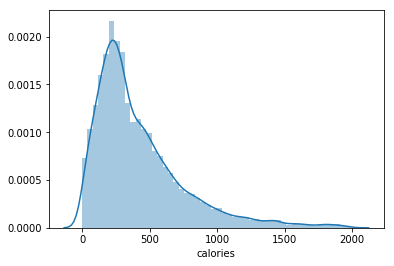

In [21]:
sns.distplot(df_train.calories[df_train.calories < 2000].dropna())

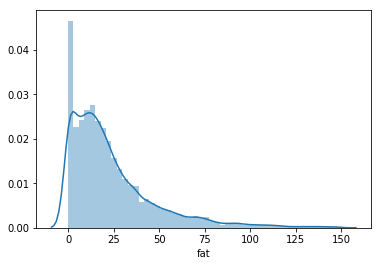

In [24]:
sns.distplot(df_train.fat[df_train.fat < 150].dropna())

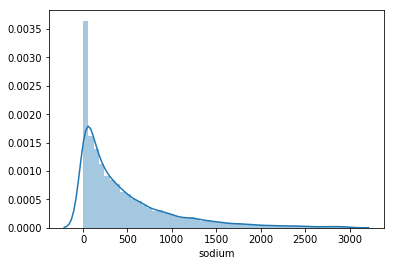

In [30]:
sns.distplot(df_train.sodium[df_train.sodium < 3000].dropna())

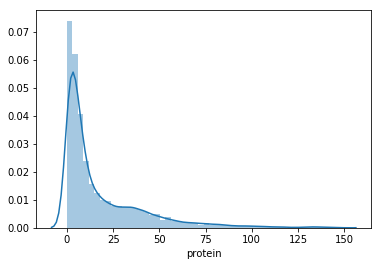

In [32]:
sns.distplot(df_train.protein[df_train.protein < 150].dropna())